# Teacher's Assignment - Extra Credit #2

***Author:*** *Ofir Paz* $\qquad$ ***Version:*** *17.07.2024* $\qquad$ ***Course:*** *22961 - Deep Learning* \
***Extra Assignment Course:*** *20999 - Extra Assignment 4*

Welcome to the first question of the extra assignment #2 as part of the course *Deep Learning*. \
In this question we will train different types of auto encoders on the MNIST dataset and compare the results with various plots.

## Imports

In [1]:
import torch  # pytorch.
import torch.nn as nn  # neural network module.
import numpy as np  # numpy - scientific calculations.
from torch.utils.data import DataLoader, Dataset  # data handling.
from sklearn.datasets import fetch_openml  # To fetch the hand-written digits dataset.
from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets.
import matplotlib.pyplot as plt  # plotting module.
from tqdm.notebook import tqdm  # Progress bar
from base_model import BaseModel  # base model class.

# Type hinting.
from torch import Tensor
from typing import Optional, Literal, Tuple

## Loading MNIST

In [2]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Access features (pixel values). We don't need the target values for autoencoders.
dataset = mnist['data']

print(f"The shape of the data array is: {dataset.shape}")

train_set, val_set = train_test_split(dataset, test_size=1/7, random_state=42)
train_set, val_set = np.array(train_set), np.array(val_set) 

print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")

The shape of the data array is: (70000, 784)
Training set shape: (60000, 784)
Validation set shape: (10000, 784)


In [3]:
# Define the dataset class for the auto encoder.
class MNISTDataset(Dataset):
    __mnist_shape__: Tuple[int, int, int] = (1, 28, 28)

    def __init__(self, data: np.ndarray):
        self.data = torch.from_numpy(data).to(torch.float32).view(-1, *self.__mnist_shape__) / 255.0

    def __len__(self) -> int:
        return self.data.size(0)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return self.data[idx], self.data[idx]  # Return the same image as input and target.

In [4]:
batch_size = 256

# Create the dataset loaders.
train_dataset = MNISTDataset(train_set)
val_dataset = MNISTDataset(val_set)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## The Fully Connected Auto Encoder

In [5]:
class BaseAutoEncoder(BaseModel):
    """Base autoencoder model.
    """
    def __init__(self, layer_parms: dict, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.save_layer_outs: bool = False
        self._layer_outs: list = []
        self._layer_parms = layer_parms

        num_layers = len(list(layer_parms.values())[0])
        assert num_layers > 0, "At least one hidden layer is required."

        encoder_layers = []
        
        encoder_layers.extend([self._make_layer(-1, "encoder")])
        for idx in range(num_layers - 1):
            encoder_layers.extend([nn.ReLU(), self._make_layer(idx, "encoder")])
        encoder_layers.extend([nn.Sigmoid()])
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        for idx in range(num_layers - 1):
            decoder_layers.extend([self._make_layer(idx, "decoder"), nn.ReLU()])
        decoder_layers.extend([self._make_layer(-1, "decoder"), nn.Sigmoid()])    
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def _make_layer(self, idx: int, trasnform_type: Literal["encoder", "decoder"]) -> nn.Module:
        raise NotImplementedError
    
    @property
    def layer_outs(self) -> list:
        self.save_layer_outs = False
        _layer_outs = self._layer_outs
        self._layer_outs = []
        return _layer_outs
    
    def _attach_hooks(self) -> None:
        assert hasattr(self, "encoder") and hasattr(self, "decoder"), \
            "Model must have 'encoder' and 'decoder' attributes."
        for layer in self.encoder:
            layer.register_forward_hook(self._hook_fn)
        for layer in self.decoder:
            layer.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module: nn.Module, input: Tuple[Tensor], output: Tensor) -> None:
        if self.save_layer_outs and isinstance(module, nn.ReLU):
            assert output.size(0) == 1, "For this operation, only 1 image in a batch is allowed."
            assert int(output.numel() ** 0.5) ** 2 == output.numel(), "Only square images are supported."
            side_len = int(output.numel() ** 0.5)
            self._layer_outs.append(output.clone().view(side_len, side_len).cpu().numpy())

In [6]:
class FCAutoEncoder(BaseAutoEncoder):
    """
    Fully connected autoencoder model.

    Args:
        input_size (int): The size of the input data.
        layers (list[int]): The size of each hidden layer.

    Attributes:
        encoder (nn.Sequential): The encoder part of the autoencoder.
        decoder (nn.Sequential): The decoder part of the autoencoder.
    """
    __input_size__: int = 28 * 28

    def __init__(self, layers: list[int], **kwargs) -> None:
        super().__init__({"layers": layers}, **kwargs)
        self._attach_hooks()

    def forward(self, x: Tensor) -> Tensor:
        x = x.view(x.size(0), -1)
        return super().forward(x)
    
    def _make_layer(self, idx: int, trasnform_type: Literal["encoder", "decoder"]) -> nn.Module:
        if trasnform_type == "encoder":
            if idx == -1:
                return nn.Linear(self.__input_size__, self._layer_parms["layers"][0])
            else:
                return nn.Linear(self._layer_parms["layers"][idx], self._layer_parms["layers"][idx+1])
            
        elif trasnform_type == "decoder":
            if idx == -1:
                return nn.Linear(self._layer_parms["layers"][0], self.__input_size__)
            else:
                return nn.Linear(self._layer_parms["layers"][-idx-1], self._layer_parms["layers"][-idx-2])
            
        else:
            raise ValueError("Invalid transform type.")

## Training The FC Auto Encoder

For training the Auto Encoder, I chose the Mean Squared Error (MSE) loss function, since it gives scores for the pixel similarity between images.

In [7]:
# Configs for different network architectures.

# This is more of a sanity check, it should be able perfectly reconstruct the input
#  as the latent space dimension is the same as the input dimension.
layers_config1 = [28 * 28]  

# This is a decent architecture, with a large enough latent space and few hidden layers.
layers_config2 = [400, 400, 64]

# This is a very small latent space, it should not be able to reconstruct the input well.
layers_config3 = [16, 4]

In [8]:
fc_autoencoder1 = FCAutoEncoder(layers_config1, job_type="regression")
fc_autoencoder1.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=3)
fc_autoencoder1.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.042415  Train MSE: 0.042]  [Val loss: 0.021939  Val MSE: 0.022]
[epoch: 04/15] [Train loss: 0.006384  Train MSE: 0.006]  [Val loss: 0.005521  Val MSE: 0.006]
[epoch: 07/15] [Train loss: 0.003328  Train MSE: 0.003]  [Val loss: 0.003122  Val MSE: 0.003]
[epoch: 10/15] [Train loss: 0.002288  Train MSE: 0.002]  [Val loss: 0.002232  Val MSE: 0.002]
[epoch: 13/15] [Train loss: 0.001769  Train MSE: 0.002]  [Val loss: 0.001770  Val MSE: 0.002]
[epoch: 15/15] [Train loss: 0.001546  Train MSE: 0.002]  [Val loss: 0.001560  Val MSE: 0.002]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.001446  Train MSE: 0.001]  [Val loss: 0.001506  Val MSE: 0.002]
[epoch: 18/25] [Train loss: 0.001407  Train MSE: 0.001]  [Val loss: 0.001470  Val MSE: 0.001]
[epoch: 20/25] [Train loss: 0.001372  Train MSE: 0.001]  [Val loss: 0.001436  Val MSE: 0.001]
[epoch: 22/25] [Train loss: 0.001341  Train MSE: 0.001]  [Val loss: 0.001407  Val MSE: 0.001]
[epoch: 24

In [9]:
fc_autoencoder2 = FCAutoEncoder(layers_config2, job_type="regression")
fc_autoencoder2.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=3)
fc_autoencoder2.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.069918  Train MSE: 0.070]  [Val loss: 0.060083  Val MSE: 0.060]
[epoch: 04/15] [Train loss: 0.032616  Train MSE: 0.033]  [Val loss: 0.029511  Val MSE: 0.030]
[epoch: 07/15] [Train loss: 0.022166  Train MSE: 0.022]  [Val loss: 0.021239  Val MSE: 0.021]
[epoch: 10/15] [Train loss: 0.017482  Train MSE: 0.017]  [Val loss: 0.016889  Val MSE: 0.017]
[epoch: 13/15] [Train loss: 0.014690  Train MSE: 0.015]  [Val loss: 0.014491  Val MSE: 0.014]
[epoch: 15/15] [Train loss: 0.013280  Train MSE: 0.013]  [Val loss: 0.013303  Val MSE: 0.013]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.012473  Train MSE: 0.012]  [Val loss: 0.012663  Val MSE: 0.013]
[epoch: 18/25] [Train loss: 0.012218  Train MSE: 0.012]  [Val loss: 0.012445  Val MSE: 0.012]
[epoch: 20/25] [Train loss: 0.012001  Train MSE: 0.012]  [Val loss: 0.012259  Val MSE: 0.012]
[epoch: 22/25] [Train loss: 0.011784  Train MSE: 0.012]  [Val loss: 0.012030  Val MSE: 0.012]
[epoch: 24

In [10]:
fc_autoencoder3 = FCAutoEncoder(layers_config3, job_type="regression")
fc_autoencoder3.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=3)
fc_autoencoder3.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.119374  Train MSE: 0.119]  [Val loss: 0.069526  Val MSE: 0.070]
[epoch: 04/15] [Train loss: 0.067481  Train MSE: 0.067]  [Val loss: 0.067200  Val MSE: 0.067]
[epoch: 07/15] [Train loss: 0.067378  Train MSE: 0.067]  [Val loss: 0.067132  Val MSE: 0.067]
[epoch: 10/15] [Train loss: 0.067353  Train MSE: 0.067]  [Val loss: 0.067120  Val MSE: 0.067]
[epoch: 13/15] [Train loss: 0.067347  Train MSE: 0.067]  [Val loss: 0.067106  Val MSE: 0.067]
[epoch: 15/15] [Train loss: 0.067348  Train MSE: 0.067]  [Val loss: 0.067113  Val MSE: 0.067]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.067325  Train MSE: 0.067]  [Val loss: 0.067084  Val MSE: 0.067]
[epoch: 18/25] [Train loss: 0.067320  Train MSE: 0.067]  [Val loss: 0.067083  Val MSE: 0.067]
[epoch: 20/25] [Train loss: 0.067319  Train MSE: 0.067]  [Val loss: 0.067080  Val MSE: 0.067]
[epoch: 22/25] [Train loss: 0.067319  Train MSE: 0.067]  [Val loss: 0.067080  Val MSE: 0.067]
[epoch: 24

## Visualizing The Encoding-Decoding Path

In [11]:
def plot_encoding_decoding_path(model: BaseAutoEncoder, input_img: Tensor, input_shape: Tuple) -> None:
    model.save_layer_outs = True
    model.eval()
    with torch.no_grad():
        output_img = model(input_img.view(*input_shape)).view(28, 28).numpy()
    layer_outs = [input_img.view(28, 28).numpy(), *model.layer_outs, output_img]
    plt.figure(figsize=(10, 7))
    for i in range(len(layer_outs) // 2):
        plt.subplot(2, len(layer_outs) // 2, i + 1)
        plt.imshow(layer_outs[i], cmap='gray')
        plt.title(f"Layer {i+1} input")

    for i in range(len(layer_outs) // 2, len(layer_outs), 1):
        plt.subplot(2, len(layer_outs) // 2, i + 1)
        plt.imshow(layer_outs[len(layer_outs) - i + len(layer_outs) // 2 - 1], cmap='gray')
        plt.title(f"Layer {len(layer_outs) - i + len(layer_outs) // 2} output")

    plt.show()

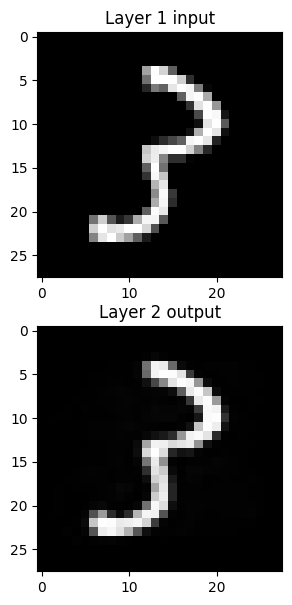

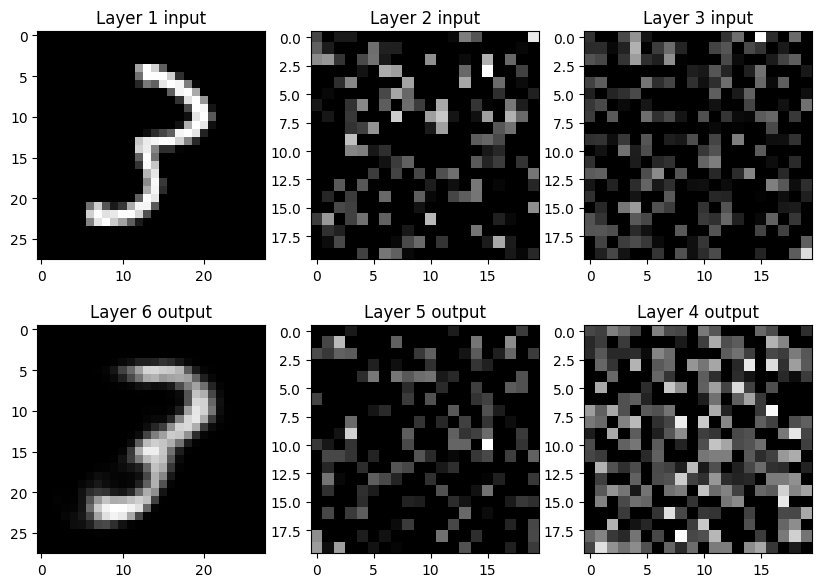

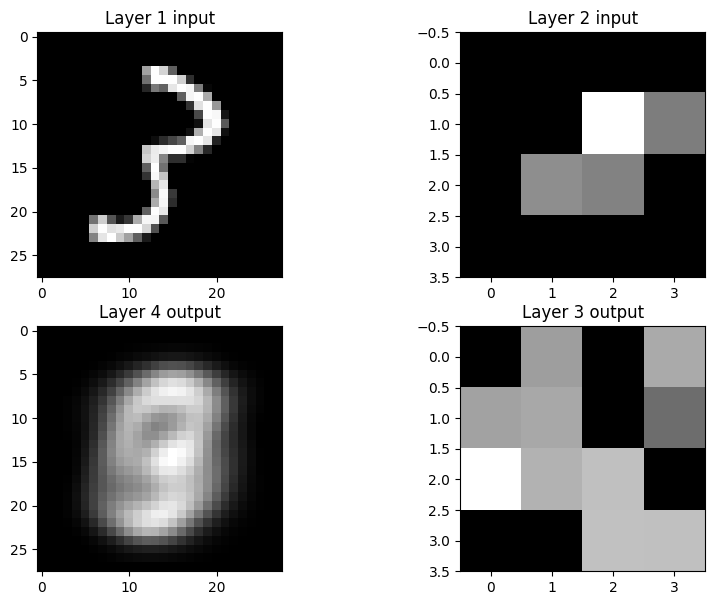

In [12]:
for fc_autoencoder in [fc_autoencoder1, fc_autoencoder2, fc_autoencoder3]:
    specific_input = val_dataset[10][0]
    plot_encoding_decoding_path(fc_autoencoder, specific_input, input_shape=(1, -1))

In [13]:
class ConvolutionalAutoEncoder(BaseAutoEncoder):
    """
    Fully connected autoencoder model.

    Args:
        input_size (int): The size of the input data.
        layers (list[int]): The size of each hidden layer.

    Attributes:
        encoder (nn.Sequential): The encoder part of the autoencoder.
        decoder (nn.Sequential): The decoder part of the autoencoder.
    """
    __input_channels__ = 1

    def __init__(self, ksizes: list[int], channels: Optional[list[int]] = None, **kwargs) -> None:
        super().__init__({
            "channels": channels if channels is not None else [self.__input_channels__] * len(ksizes), 
            "ksizes": ksizes
            }, **kwargs)

        if not channels or np.all(np.array(channels) == 1):
            self._attach_hooks()

    def forward(self, x: Tensor) -> Tensor:
        return super().forward(x)
    
    def _make_layer(self, idx: int, trasnform_type: Literal["encoder", "decoder"]) -> nn.Module:
        if trasnform_type == "encoder":
            if idx == -1:
                return nn.Conv2d(self.__input_channels__, self._layer_parms["channels"][0], 
                                 self._layer_parms["ksizes"][0])
            
            return nn.Conv2d(self._layer_parms["channels"][idx], self._layer_parms["channels"][idx+1], 
                             self._layer_parms["ksizes"][idx])
            
        elif trasnform_type == "decoder":
            if idx == -1:
                return nn.ConvTranspose2d(self._layer_parms["channels"][0], self.__input_channels__, 
                                          self._layer_parms["ksizes"][0])
            
            return nn.ConvTranspose2d(self._layer_parms["channels"][-idx-1], 
                                      self._layer_parms["channels"][-idx-2],
                                      self._layer_parms["ksizes"][-idx-1])
            
        else:
            raise ValueError("Invalid transform type.")

In [14]:
# This is a sanity check, the model should be able to perfectly reconstruct the input.
ksizes1 = [1]

# This is a decent architecture, with a large enough latent space and few hidden layers.
ksizes2 = [7, 7]  # Latent space is (28 - 6 - 6)^2 = 256

# Good architecture with multiple channels (cannot be displayed).
channels3 = [2, 2, 2]; ksizes3 = [7, 7, 7]  # Latent space is (28 - 6 - 6 - 6)^2 * 2 = 200

In [15]:
conv_autoencoder1 = ConvolutionalAutoEncoder(ksizes1, job_type="regression")
conv_autoencoder1.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=3)
conv_autoencoder1.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.384207  Train MSE: 0.384]  [Val loss: 0.337276  Val MSE: 0.337]
[epoch: 04/15] [Train loss: 0.186699  Train MSE: 0.187]  [Val loss: 0.169694  Val MSE: 0.170]
[epoch: 07/15] [Train loss: 0.124479  Train MSE: 0.124]  [Val loss: 0.118941  Val MSE: 0.119]
[epoch: 10/15] [Train loss: 0.102147  Train MSE: 0.102]  [Val loss: 0.099358  Val MSE: 0.099]
[epoch: 13/15] [Train loss: 0.090950  Train MSE: 0.091]  [Val loss: 0.089158  Val MSE: 0.089]
[epoch: 15/15] [Train loss: 0.085870  Train MSE: 0.086]  [Val loss: 0.084276  Val MSE: 0.084]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.084464  Train MSE: 0.084]  [Val loss: 0.083829  Val MSE: 0.084]
[epoch: 18/25] [Train loss: 0.083535  Train MSE: 0.084]  [Val loss: 0.082893  Val MSE: 0.083]
[epoch: 20/25] [Train loss: 0.082554  Train MSE: 0.083]  [Val loss: 0.081906  Val MSE: 0.082]
[epoch: 22/25] [Train loss: 0.081522  Train MSE: 0.082]  [Val loss: 0.080870  Val MSE: 0.081]
[epoch: 24

In [16]:
conv_autoencoder2 = ConvolutionalAutoEncoder(ksizes2, job_type="regression")
conv_autoencoder2.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=3)
conv_autoencoder2.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.162917  Train MSE: 0.163]  [Val loss: 0.122878  Val MSE: 0.123]
[epoch: 04/15] [Train loss: 0.115107  Train MSE: 0.115]  [Val loss: 0.113968  Val MSE: 0.114]
[epoch: 07/15] [Train loss: 0.113483  Train MSE: 0.113]  [Val loss: 0.112667  Val MSE: 0.113]
[epoch: 10/15] [Train loss: 0.112929  Train MSE: 0.113]  [Val loss: 0.112191  Val MSE: 0.112]
[epoch: 13/15] [Train loss: 0.112679  Train MSE: 0.113]  [Val loss: 0.111971  Val MSE: 0.112]
[epoch: 15/15] [Train loss: 0.112585  Train MSE: 0.113]  [Val loss: 0.111886  Val MSE: 0.112]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.112549  Train MSE: 0.113]  [Val loss: 0.111851  Val MSE: 0.112]
[epoch: 18/25] [Train loss: 0.112496  Train MSE: 0.112]  [Val loss: 0.111805  Val MSE: 0.112]
[epoch: 20/25] [Train loss: 0.112464  Train MSE: 0.112]  [Val loss: 0.111777  Val MSE: 0.112]
[epoch: 22/25] [Train loss: 0.112442  Train MSE: 0.112]  [Val loss: 0.111757  Val MSE: 0.112]
[epoch: 24

In [17]:
conv_autoencoder3 = ConvolutionalAutoEncoder(ksizes3, channels3, job_type="regression")
conv_autoencoder3.fit(train_loader, val_loader, num_epochs=15, lr=0.001, print_stride=3)
conv_autoencoder3.fit(train_loader, val_loader, num_epochs=10, lr=0.0001, print_stride=2)

Using CUDA for training.
[epoch: 01/15] [Train loss: 0.128742  Train MSE: 0.129]  [Val loss: 0.084069  Val MSE: 0.084]
[epoch: 04/15] [Train loss: 0.064173  Train MSE: 0.064]  [Val loss: 0.058981  Val MSE: 0.059]
[epoch: 07/15] [Train loss: 0.048911  Train MSE: 0.049]  [Val loss: 0.046527  Val MSE: 0.047]
[epoch: 10/15] [Train loss: 0.037831  Train MSE: 0.038]  [Val loss: 0.036586  Val MSE: 0.037]
[epoch: 13/15] [Train loss: 0.033325  Train MSE: 0.033]  [Val loss: 0.032822  Val MSE: 0.033]
[epoch: 15/15] [Train loss: 0.031855  Train MSE: 0.032]  [Val loss: 0.031572  Val MSE: 0.032]
Using CUDA for training.
[epoch: 16/25] [Train loss: 0.031304  Train MSE: 0.031]  [Val loss: 0.031195  Val MSE: 0.031]
[epoch: 18/25] [Train loss: 0.031078  Train MSE: 0.031]  [Val loss: 0.030966  Val MSE: 0.031]
[epoch: 20/25] [Train loss: 0.030859  Train MSE: 0.031]  [Val loss: 0.030743  Val MSE: 0.031]
[epoch: 22/25] [Train loss: 0.030631  Train MSE: 0.031]  [Val loss: 0.030516  Val MSE: 0.031]
[epoch: 24

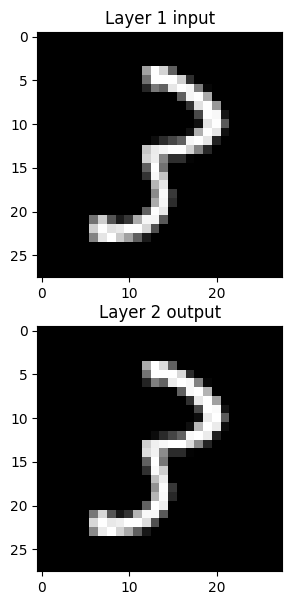

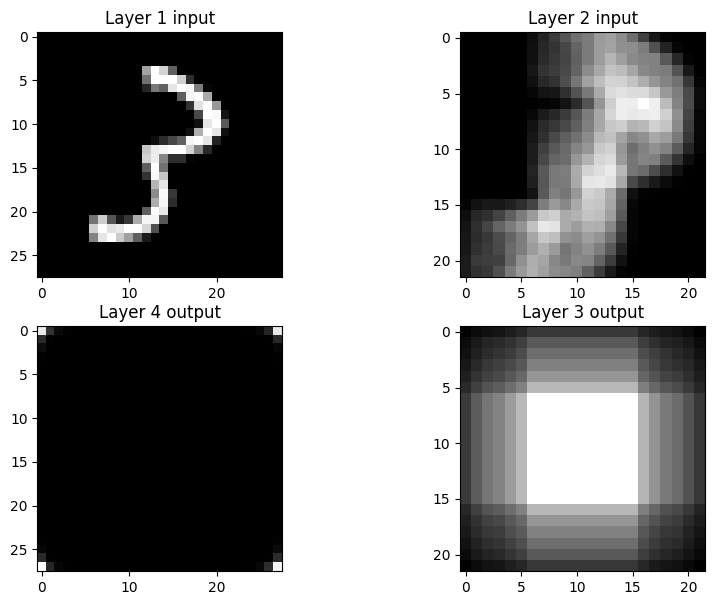

In [18]:
for conv_autoencoder in [conv_autoencoder1, conv_autoencoder2]:
    specific_input = val_dataset[10][0]
    plot_encoding_decoding_path(conv_autoencoder, specific_input, input_shape=(1, 28, 28))

## Conclusions

We explored the MLP Auto Encoder vs the Fully Convolutional Auto Encoder on the MNIST dataset.

We saw that the MLP Auto Encoder performs overall better than the fully convolutional one, probably because the convolutional one lacks fully connected layers, which are crucial for its receptive field.

Also, the larger the laten space the network has the better it performs, since it doens't have to encode the image into a smaller space.

Choosing the network parameters and the architecture is obviously crucial for the network's performance.

We chose MSE as the loss function since it evaluates the model based on the pixel similarity between the original and the reconstructed image, which is exactly the metric we want to optimize.